# CS304 Unit #7 Assignment Notebook

Use this notebook to complete the unit #7 homework assignment

Student: Bibiane Paradis

In [21]:
%matplotlib inline

import numpy as np
import string
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sbn
from altair import Chart, X, Y, Color, Scale
import altair as alt
from nltk.corpus import stopwords
matplotlib.style.use('ggplot')

In [22]:
# 1. setup data

# original URL: https://www.kaggle.com/datasets/sulmansarwar/transactions-from-a-bakery

products = pd.read_csv('BreadBasket_DMS.csv')
print("Dataframe shape:", products.shape)
products.head()

Dataframe shape: (21293, 4)


,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [23]:
# 2. clean data (look at all values, determine what should be removed and remove it)

# hint: https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html

# -- find unique item values and counts -- 
item_counts = products['Item'].value_counts(dropna=False)
print("Unique item count:", len(item_counts))
item_counts.head(40) #shows the top 40 unique values

# -- remove bad value rows -- 
bad_values = ['NONE', '', '0', 'NULL'] #removes items that have 'NONE'
products['Item'] = products['Item'].astype(str).str.strip() # standardize whitespace and casesaftey

mask_bad = products['Item'].isin(bad_values) | products['Item'].str.lower().isin([str(x).lower() for x in bad_values])
mask_na = products['Item'].isnull() | (products['Item']=='nan')

print("Rows before cleaning:", len(products))
products_clean = products.loc[~(mask_bad | mask_na)].copy()
print("Row after cleaning:", len(products_clean))

#shows the unique items now
print("Unique item after cleaning:", products_clean['Item'].nunique())
products_clean['Item'].value_counts().head(30)

Unique item count: 95
Rows before cleaning: 21293
Row after cleaning: 20507
Unique item after cleaning: 94


Item
Coffee               5471
Bread                3325
Tea                  1435
Cake                 1025
Pastry                856
Sandwich              771
Medialuna             616
Hot chocolate         590
Cookies               540
Brownie               379
Farm House            374
Muffin                370
Alfajores             369
Juice                 369
Soup                  342
Scone                 327
Toast                 318
Scandinavian          277
Truffles              193
Coke                  185
Spanish Brunch        172
Fudge                 159
Baguette              152
Jam                   149
Tiffin                146
Mineral water         136
Jammie Dodgers        125
Chicken Stew          123
Hearty & Seasonal     107
Salad                  99
Name: count, dtype: int64

In [24]:
#3 develop item-item dictionary

#group by the transaction column and collect items per transaction
if 'Transaction' in products_clean.columns:
    transaction = products_clean.groupby('Transaction')['Item'].apply(list)
else:
    # if column is named differently, print columns
    print("Columns found:", products_clean.columns)
    raise KeyError("No 'Transaction' column found.")

#convert to a list indexed by transaction id
transactions = transaction.sort_index() #ensures deterministic ordering
print("Number of transaction:", len(transactions))
transactions.head(10)

#build an item-item dictonary

#sort unique items in list
items = sorted(products_clean['Item'].unique())
print("Number of distinct items:", len(items))

#initialize co-occurence dictionary
from collections import defaultdict
co = defaultdict(lambda: defaultdict(int))

#for each transaction, increment counts for each unordered pairs
for trx_items in transactions:
    unique_items = sorted(set(trx_items))
    for i in range(len(unique_items)):
        for j in range(i+1, len(unique_items)):
            a = unique_items[i]
            b = unique_items[j]
            co[a][b] += 1
            co[b][a] += 1

co_df = pd.DataFrame(index=items, columns=items, dtype=float)
for a in items:
    for b in items:
        if a == b:
            co_df.at[a,b] = np.nan
        else:
            co_df.at[a,b] = co[a].get(b, 0)

#verify shape
print("co-occurrence matrix shape:", co_df.shape)
co_df.iloc[:6, :6]

Number of transaction: 9465
Number of distinct items: 94
co-occurrence matrix shape: (94, 94)


,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon
Adjustment,NaN,0.0,0.0,0.0,0.0,0.0
Afternoon with the baker,0.0,NaN,0.0,2.0,0.0,0.0
Alfajores,0.0,0.0,NaN,0.0,3.0,0.0
Argentina Night,0.0,2.0,0.0,NaN,0.0,0.0
Art Tray,0.0,0.0,3.0,0.0,NaN,1.0
Bacon,0.0,0.0,0.0,0.0,1.0,NaN


In [25]:
# 4 clean data by replacing na's with 0's

co_df_filled = co_df.fillna(0).astype(int)
co_df_filled.iloc[:6, :6]


,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon
Adjustment,0,0,0,0,0,0
Afternoon with the baker,0,0,0,2,0,0
Alfajores,0,0,0,0,3,0
Argentina Night,0,2,0,0,0,0
Art Tray,0,0,3,0,0,1
Bacon,0,0,0,0,1,0


In [33]:
# 5 

#helper to get pair counts
def pair_count(a,b):
    if a not in co_df_filled.index or b not in co_df_filled.columns:
        return 0
    return int(co_df_filled.at[a,b])

#Q1: How many times tea and coffee were bought together?
print("Available items sample (first 40):", items[:40])

#use exact strings found in items- coffee and tea together
tea_name = next((it for it in items if it.lower()=='tea'), None)
coffee_name = next((it for it in items if it.lower()=='coffee'), None)

if tea_name and coffee_name:
    tea_coffee_count = pair_count(tea_name, coffee_name)
else:
    tea_cofee_count = None
print('How many times tea and coffee were bought together:', tea_coffee_count)

#Q2: What item was most often purchased with vegan mincepie?

#find the exact item string
candidates = [it for it in items if 'vegan' in it.lower() or 'mince' in it.lower()]
print("Possible vegan/mince names found:", candidates)

if candidates:
    vm = candidates[0]
    # find top co-occurring item for vm
    row = co_df_filled.loc[vm].copy()
    row_sorted = row.sort_values(ascending=False)
    most_with_vm = row_sorted.index[0]
    most_with_vm_count = int(row_sorted.iloc[0])
    print("The item most often purchased with", vm, "is", most_with_vm, "(", most_with_vm_count, "times )")
else:
    print("No 'vegan mincepie' like item found.")

#Q3: What two items were most frequently bought together?
#unstack the upper triangle and find max
pairs = []
for i, a in enumerate(items):
    for j, b in enumerate(items):
        if j <= i: 
            continue  #only consider each unordered pair once
        count = int(co_df_filled.at[a,b])
        pairs.append(((a,b), count))

pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)
top_pair, top_count = pairs_sorted[0]
print("The two items most frequently bought together:", top_pair, "with count =", top_count)



Available items sample (first 40): ['Adjustment', 'Afternoon with the baker', 'Alfajores', 'Argentina Night', 'Art Tray', 'Bacon', 'Baguette', 'Bakewell', 'Bare Popcorn', 'Basket', 'Bowl Nic Pitt', 'Bread', 'Bread Pudding', 'Brioche and salami', 'Brownie', 'Cake', 'Caramel bites', 'Cherry me Dried fruit', 'Chicken Stew', 'Chicken sand', 'Chimichurri Oil', 'Chocolates', 'Christmas common', 'Coffee', 'Coffee granules', 'Coke', 'Cookies', 'Crepes', 'Crisps', 'Drinking chocolate spoons', 'Duck egg', 'Dulce de Leche', 'Eggs', "Ella's Kitchen Pouches", 'Empanadas', 'Extra Salami or Feta', 'Fairy Doors', 'Farm House', 'Focaccia', 'Frittata']
How many times tea and coffee were bought together: 472
Possible vegan/mince names found: ['Vegan Feast', 'Vegan mincepie']
The item most often purchased with Vegan Feast is Coffee ( 2 times )
The two items most frequently bought together: ('Bread', 'Coffee') with count = 852


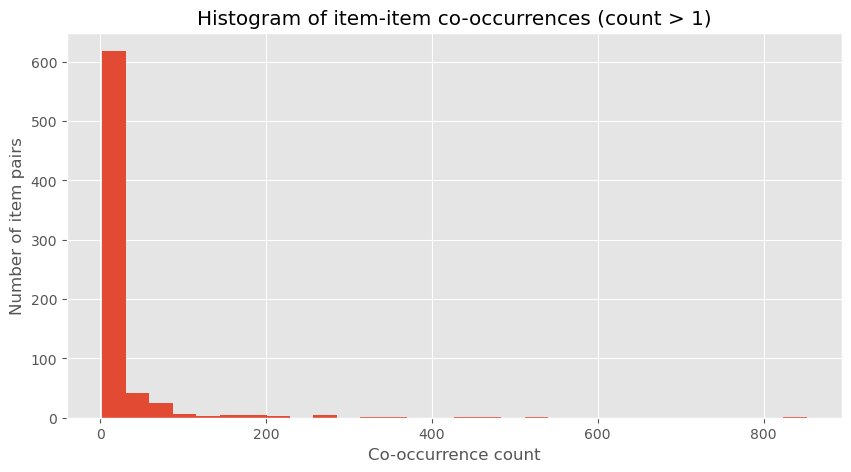

In [34]:
# 6a develop histogram of item co-occurances (more than just once)

#flatten upper triangle to a 1D list of counts
vals = []
for i, a in enumerate(items):
    for j, b in enumerate(items):
        if j <= i: 
            continue
        v = int(co_df_filled.at[a,b])
        if v > 0:
            vals.append(v)

vals = np.array(vals)
len(vals), vals.min(), vals.max(), np.mean(vals)

#6a
vals_gt1 = vals[vals > 1]

plt.figure(figsize=(10,5))
plt.hist(vals_gt1, bins=30)
plt.title('Histogram of item-item co-occurrences (count > 1)')
plt.xlabel('Co-occurrence count')
plt.ylabel('Number of item pairs')
plt.show()

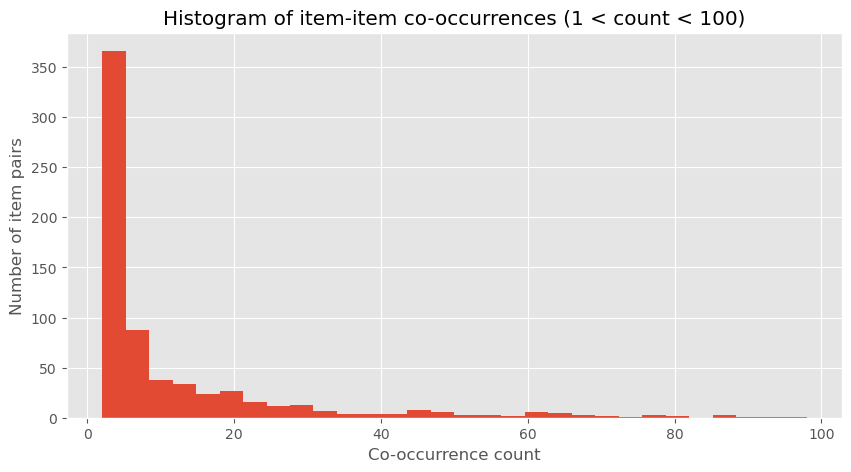

In [38]:
# 6b develop histogram of item co-occurances (more than just once) and fewer than 100 times

vals_zoom = vals[(vals > 1) & (vals < 100)]

plt.figure(figsize=(10,5))
plt.hist(vals_zoom, bins=30)
plt.title('Histogram of item-item co-occurrences (1 < count < 100)')
plt.xlabel('Co-occurrence count')
plt.ylabel('Number of item pairs')
plt.show()